In [6]:
import numpy as np
import pandas as pd
import mplfinance as mpf
import os
from glob import glob
import matplotlib.pyplot as plt

%matplotlib inline

#import talib as ta # conda activate cryt310
from matplotlib.ticker import AutoMinorLocator
import time
from itertools import zip_longest 
import datetime
import schedule
import json,requests
from funcs import *
import pickle
import warnings

warnings.simplefilter("error")

%load_ext autoreload
%autoreload 2

tickerpair="ETCUSDT" #GBPUSDT #LTCUSDT #ETHUSDT #BTCUSDT
#tickerpair="BNBUSDT" #BNBUSDT #AUDUSDT #XMRUSDT
tickerpairs=["ETCUSDT","GBPUSDT","LTCUSDT","ETHUSDT","BTCUSDT","BNBUSDT","AUDUSDT","XMRUSDT"] 

intervals=['1m','3m','5m','15m','30m','1h','2h','3h','4h','6h','8h','12h','1d','3d','1w','1Month']

# define constants
tickerpair="ETCUSDT"
interval="5m"  
intervals=['5m','15m','30m']#[-1:]
tickerpairs=['ARBUSDT', 'AVAXUSDT', 'BCHUSDT', 'BNBUSDT', 'BTCUSDT',
             'ETCUSDT', 'ETHUSDT', 'LTCUSDT', 'MATICUSDT','SHIBUSDT', 
             'SOLUSDT','WAVESUSDT','XRPUSDT']
tickerpairs=os.listdir("kline_data/")
#tickerpairs=["ARBUSDT","ETCUSDT","LTCUSDT","ETHUSDT","BTCUSDT","BNBUSDT","XVGUSDT"]#[:1]
with open('trading_pairs.pkl', 'rb') as f:
    trading_pairs = pickle.load(f)
tickerpairs = [t["symbol"] for t in trading_pairs[:10]]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [275]:
%%time
dfmpl = get_data(tickerpair,"15m",limit=55000,type="data").iloc[-50400:]

CPU times: total: 469 ms
Wall time: 698 ms


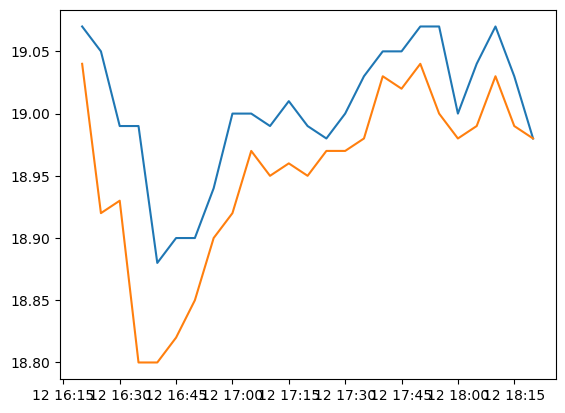

In [72]:
plt.plot(dfmpl.High.iloc[-25:])
plt.plot(dfmpl.Low.iloc[-25:])

Text(0.5, 1.0, 'Open          16.49\nHigh          16.49\nLow           12.61\nClose         13.44\nVolume    301669.47\nName: 2023-06-10 07:15:00, dtype: float64')

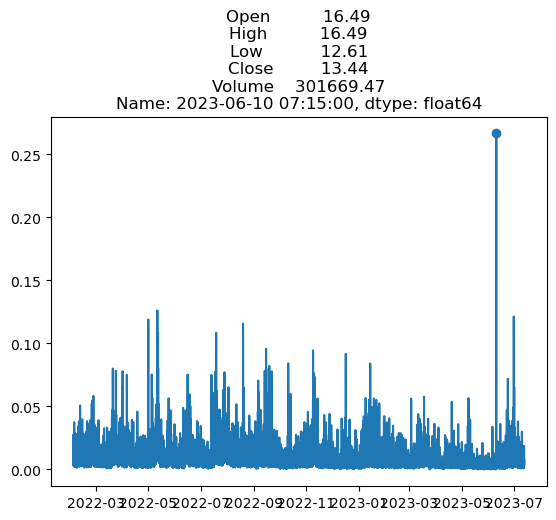

In [276]:
amp=(dfmpl.High-dfmpl.Low)/(dfmpl.High+dfmpl.Low)*2
plt.plot(amp)
plt.scatter(dfmpl.iloc[amp.argmax()].name,amp.max())
plt.title(f"{dfmpl.iloc[amp.argmax()]}")

Text(0.5, 1.0, 'amplitude every 5mins averaged over the days')

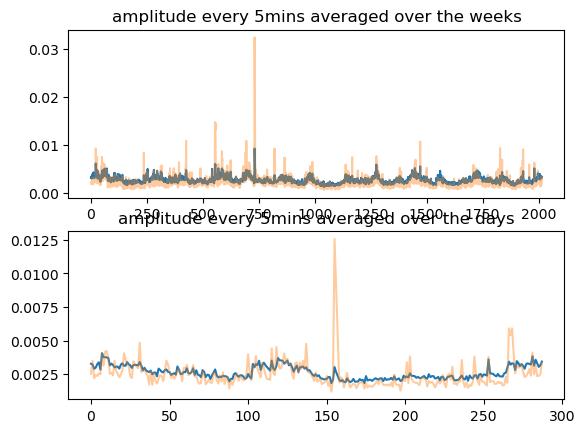

In [74]:
fig,axx=plt.subplots(2,1)
ax=axx[0]
#ax.plot(np.asarray(amp).reshape(2016,-1).mean(axis=1))
ax.plot(np.asarray(amp).reshape(-1,2016).mean(axis=0))
ax.plot(np.asarray(amp).reshape(-1,2016).std(axis=0),alpha=0.4)
#ax.plot(np.asarray(amp).reshape(2016,-1).std(axis=1),alpha=0.4)
ax.set_title("amplitude every 5mins averaged over the weeks")
ax=axx[1]
ax.plot(np.asarray(amp).reshape(-1,2016//7).mean(axis=0))
ax.plot(np.asarray(amp).reshape(-1,2016//7).std(axis=0),alpha=0.4)
#ax.plot(np.asarray(amp).reshape(2016//7,-1).mean(axis=1))
#ax.plot(np.asarray(amp).reshape(2016//7,-1).std(axis=1),alpha=0.4)
ax.set_title("amplitude every 5mins averaged over the days")

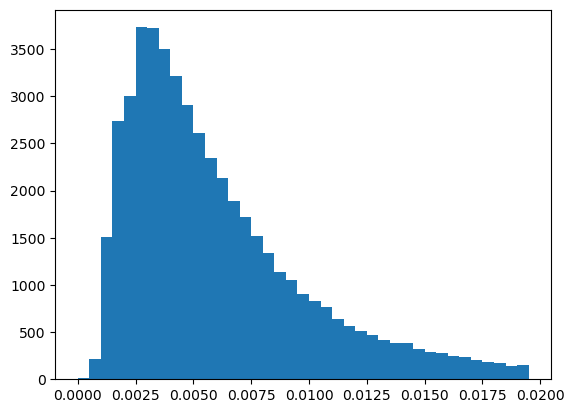

In [277]:
plt.hist(amp,bins=np.arange(0,0.02,0.0005));

In [278]:
bigamp_indexs = np.where((amp>0.01) & (amp<0.02))[0]
bigamp_indexs = np.where(amp>0.015)[0]
dfmpl.iloc[bigamp_indexs]

,Open,High,Low,Close,Volume
Date,,,,,
2022-02-02 19:00:00,27.17,27.18,26.74,26.92,61720.37
2022-02-02 19:15:00,26.92,27.29,26.79,27.13,29592.11
2022-02-03 00:15:00,26.99,27.13,26.58,26.83,30999.62
2022-02-03 00:30:00,26.83,26.92,26.18,26.41,48586.76
2022-02-03 01:00:00,26.57,26.81,26.40,26.43,22933.91
...,...,...,...,...,...
2023-07-07 15:30:00,18.82,19.14,18.81,18.95,33566.53
2023-07-07 16:15:00,19.00,19.26,18.96,19.18,41733.02
2023-07-10 03:00:00,18.62,18.65,18.10,18.28,81417.58


In [279]:
np.where(np.diff(bigamp_indexs)==1)[0]

array([   0,    2,   13, ..., 3878, 3881, 3882], dtype=int64)

In [288]:
conseq = bigamp_indexs[np.where(np.diff(bigamp_indexs)==1)[0]]
conseq+=1
conseq2  = conseq[np.where(np.diff(conseq)==1)[0]]
conseq = conseq2+1

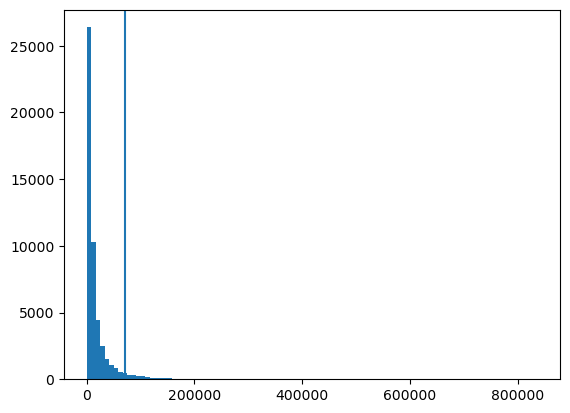

In [289]:
vol_thres = np.percentile(dfmpl.Volume,95)
plt.hist(dfmpl.Volume,bins=100);
plt.axvline(vol_thres)

In [290]:
selected = conseq[np.where(dfmpl.iloc[conseq].Volume>vol_thres)]

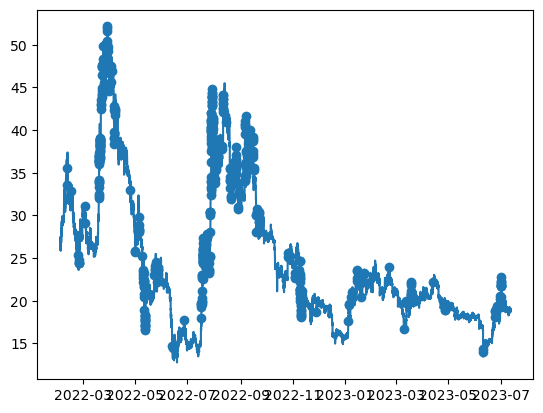

In [291]:
plt.plot(dfmpl.Close)
plt.scatter(dfmpl.iloc[selected].index,dfmpl.iloc[selected].Close)

# does big amps correlate with higher close than open in the next candle?

In [292]:
#Close = dfmpl.iloc[bigamp_indexs+1].Close
#Open = dfmpl.iloc[bigamp_indexs+1].Open
Close = dfmpl.iloc[selected+1].Close
Open = dfmpl.iloc[selected+1].Open 
diff = (Close-Open)/Open

In [293]:
diff.shape

(523,)

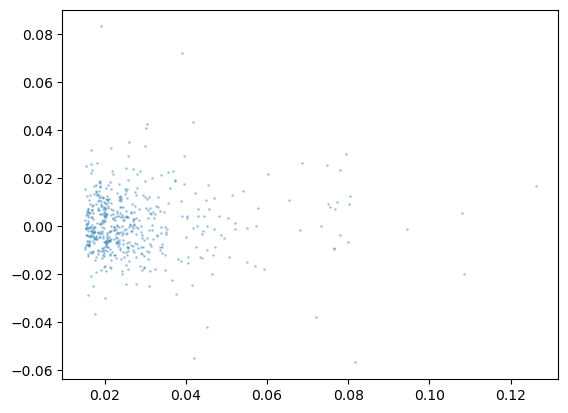

In [294]:
plt.scatter(amp.iloc[selected].values,diff.values,s=1,alpha=0.3)

In [295]:
np.mean(diff.values),np.mean(diff.values)*100,np.mean(diff.values>0)

(0.0006031692003107203, 0.06031692003107204, 0.4646271510516252)

In [296]:
import talib as ta

In [299]:
%%time
macd,    macdsignal,    macdhist=ta.MACD(dfmpl.Close)

CPU times: total: 0 ns
Wall time: 3 ms


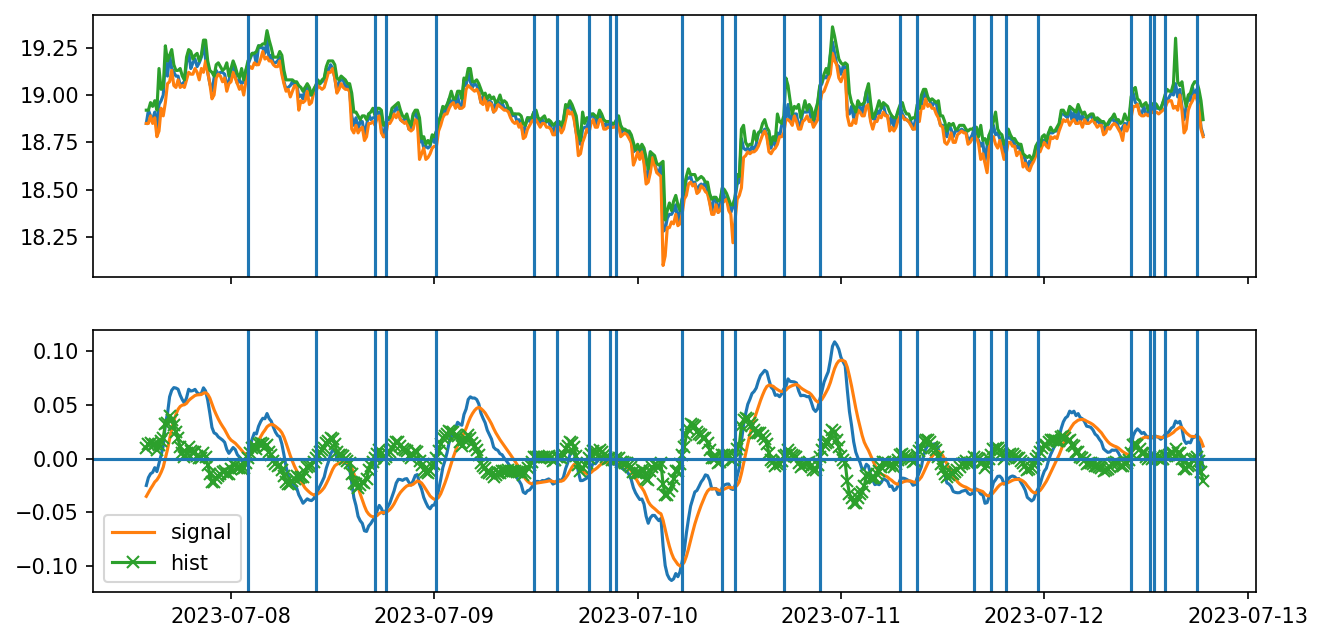

In [339]:
fig,axx=plt.subplots(2,1,figsize=(10,5),sharex=True,dpi=150)
lastN=-500
ax=axx[0]
ax.plot(dfmpl.iloc[lastN:].Close)
ax.plot(dfmpl.iloc[lastN:].Low)
ax.plot(dfmpl.iloc[lastN:].High)
ax=axx[1]
ax.plot(macd.iloc[lastN:])
ax.plot(macdsignal.iloc[lastN:],label="signal")
ax.plot(macdhist.iloc[lastN:],label="hist",marker="x")
ax.axhline(0)

x=np.where(macdhist.iloc[lastN:]>0)[0]
cross_overs = x[np.where(np.diff(x)>1)[0]+1]
for c in cross_overs:
    for ax in axx:
        ax.axvline(dfmpl.iloc[lastN:].iloc[c].name)
ax.legend()

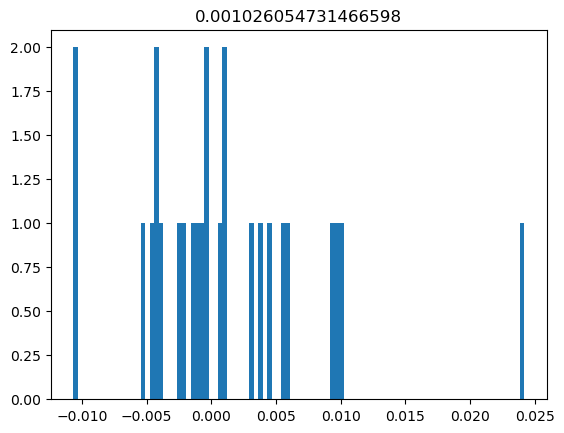

In [351]:
gains=(dfmpl.iloc[cross_overs+2].Close.values - dfmpl.iloc[cross_overs+1].Open.values)/dfmpl.iloc[cross_overs+1].Open.values
plt.title(np.mean(gains))
plt.hist(gains,bins=100);